# COVID 19 Severity Prediction  
**Goal**: For a given individual who is diagnosed with COVID 19 we want to determine the severity of their infection in terms of the probability of decease and probability of ICU admittance.  
**Dataset**: The dataset available to us is curated by the Mexico Government and contains information for 500k+ observations. It contains information regarding the result of the test, time of detection, demographic information and most importantly that of various health conditions.  

## Data Preparation

In [372]:
import pandas as pd
import numpy as np

In [373]:
# Import and asses dataset
# Dataset description can be found at: https://www.kaggle.com/tanmoyx/covid19-patient-precondition-dataset?select=covid.csv
df = pd.read_csv("../data/mexico_government_covid19_patient/covid.csv")
print(df.shape)
df.head()

(566602, 23)


,id,sex,patient_type,entry_date,date_symptoms,date_died,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,9999-99-99,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,9999-99-99,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,9999-99-99,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,9999-99-99,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,22-04-2020,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


If the date_died is invalid then the given case of COVID 19 did not result in fatality. So we form a new feature "lethal" indicating this. All invalid dates are replaced with no(2), and all valid dates are replaced with 1(yes).

In [374]:
# Change the data died column to indicate if patient death
# If there is a valid date then patient death and represent as 1 otherwise represent as 2
df['date_died'] = df['date_died'].replace(to_replace="9999-99-99", value=2)
df['date_died'] = df['date_died'].mask(df['date_died'].ne(2), 1)
df = df.rename(columns={'date_died':'lethal'})
df.head()

,id,sex,patient_type,entry_date,date_symptoms,lethal,intubed,pneumonia,age,pregnancy,...,inmsupr,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu
0,16169f,2,1,04-05-2020,02-05-2020,2,97,2,27,97,...,2,2,2,2,2,2,2,2,1,97
1,1009bf,2,1,19-03-2020,17-03-2020,2,97,2,24,97,...,2,2,2,2,2,2,2,99,1,97
2,167386,1,2,06-04-2020,01-04-2020,2,2,2,54,2,...,2,2,2,2,1,2,2,99,1,2
3,0b5948,2,2,17-04-2020,10-04-2020,2,2,1,30,97,...,2,2,2,2,2,2,2,99,1,2
4,0d01b5,1,2,13-04-2020,13-04-2020,1,2,2,60,2,...,2,1,2,1,2,2,2,99,1,2


The features entry_date and date_symptoms provide valuable information, but by themselves they are not relevant to determining the severity of COVID 19. A more relevant feature would be the time between entry_date and data_symptoms. So we create a feature by subtracting these two values.

In [375]:
# With date_symptoms and entry_date we can calculate time between disease contraction and medical attention
# This would be a more relevant feature to use rather than just the dates
df['days_to_medical_help'] = (pd.to_datetime(df['entry_date'], dayfirst=True) - pd.to_datetime(df['date_symptoms'], dayfirst=True)).dt.days
df = df.drop(columns=['entry_date', 'date_symptoms'])
df.head()

,id,sex,patient_type,lethal,intubed,pneumonia,age,pregnancy,diabetes,copd,...,hypertension,other_disease,cardiovascular,obesity,renal_chronic,tobacco,contact_other_covid,covid_res,icu,days_to_medical_help
0,16169f,2,1,2,97,2,27,97,2,2,...,2,2,2,2,2,2,2,1,97,2
1,1009bf,2,1,2,97,2,24,97,2,2,...,2,2,2,2,2,2,99,1,97,2
2,167386,1,2,2,2,2,54,2,2,2,...,2,2,2,1,2,2,99,1,2,5
3,0b5948,2,2,2,2,1,30,97,2,2,...,2,2,2,2,2,2,99,1,2,7
4,0d01b5,1,2,1,2,2,60,2,1,2,...,1,2,1,2,2,2,99,1,2,0


In [376]:
# Drop Patient ID from the dataset since it won't help in predictions
columns_to_drop = ['id']
df = df.drop(columns=columns_to_drop)

In [377]:
# Check data types of all features
df.dtypes

sex                      int64
patient_type             int64
lethal                  object
intubed                  int64
pneumonia                int64
age                      int64
pregnancy                int64
diabetes                 int64
copd                     int64
asthma                   int64
inmsupr                  int64
hypertension             int64
other_disease            int64
cardiovascular           int64
obesity                  int64
renal_chronic            int64
tobacco                  int64
contact_other_covid      int64
covid_res                int64
icu                      int64
days_to_medical_help     int64
dtype: object

Now even though we know that most of these variables are categorical pandas has encoded them as int or floats so we must convert them to categorical. We also would want to normalize all non-categorical variables and replace missing values encoded as 97, 98, and 99 in the categorical variable. We also change the encoding from 2 -> No to 0 -> to No.

In [378]:
# Since most categorical features are currently int64 change them to categorical
# We also want to normalize all non categorical features
from sklearn.preprocessing import MinMaxScaler
from joblib import dump, load
categorical_columns = ['sex', 'patient_type',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco', 'contact_other_covid',
       'covid_res', 'icu', 'lethal']
# The dataset indicates that missing values are 97, 98, 99 so we replace them with -1 for uniformity
scalers = {}
for column in df.columns:
    if column in categorical_columns:
        # Change no encoding from 2 to 0
        df[column] = df[column].replace(to_replace=2, value=0)
        # Replace all missing values with -1
        df[column] = df[column].replace(to_replace=[97, 98, 99], value=-1).astype('category')
    else:
        # Normalize non categorical features
        scalers[column] = MinMaxScaler().fit(np.array(df[column]).reshape(-1, 1))
        df[column] = scalers[column].transform(np.array(df[column]).reshape(-1, 1))[:, 0]
        dump(scalers[column], str(column) + '_scaler.joblib') 

In [379]:
# Now we can only use observations in which the individual tested postive for COVID 19
covid_cases = df[df['covid_res'] == 1]
covid_cases.shape

(220657, 21)

In [380]:
# Encoding of 3 for 'covid_res' is supposed to be awaiting results so we can use these as the prediction set for risk assesment
awaiting_cases = df[df['covid_res'] == 3]
awaiting_cases.shape

(66910, 21)

In [381]:
# Variables to store the outcomes and features
# We could try combining icu and death
# However we do not want to include either in the prediction for the other due to expected high dependency
features = ['sex', 'patient_type', 'age', 'days_to_medical_help',
       'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']
"""features = ['sex', 'age', 'days_to_medical_help', 'intubed', 'pneumonia', 'pregnancy', 'diabetes', 'copd',
       'asthma', 'inmsupr', 'hypertension', 'other_disease', 'cardiovascular',
       'obesity', 'renal_chronic', 'tobacco']"""
outcomes = ['icu', 'death']

## ICU Predictions

In [382]:
# First we train a model to predict 'icu' for that we form a dataset of known icu cases i.e Yes or No so we remove 0s which were
# supposed to be missing values or cases in which we do not know if the individual was in the icu
current_outcome = outcomes[0] # i.e 'icu'
icu_res_known = covid_cases[covid_cases['icu'] != -1]
icu_res_known.shape

(68210, 21)

In [383]:
# Split data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(icu_res_known, shuffle=True, test_size=0.3, stratify=icu_res_known['icu'])

In [384]:
train[features].columns

Index(['sex', 'patient_type', 'age', 'days_to_medical_help', 'intubed',
       'pneumonia', 'pregnancy', 'diabetes', 'copd', 'asthma', 'inmsupr',
       'hypertension', 'other_disease', 'cardiovascular', 'obesity',
       'renal_chronic', 'tobacco'],
      dtype='object')

<AxesSubplot:xlabel='icu', ylabel='count'>

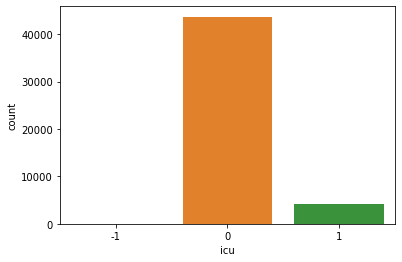

In [385]:
# Before we train we want to check the distribution of icu in the train set to ensure proper training
import seaborn as sns
import matplotlib.pyplot as plt
sns.countplot(x='icu', data=train)

In [386]:
# Evaluate all models for "icu"
# Form train test
icu_scores = allModelEvaluation(names, classifiers, train[features], train['icu'], test[features], test['icu'])

Training Decision Tree
Train Accuracy: 0.9700504743753534
Train Precision: [0.97002403 0.97047314]
Train Recall: [0.99809947 0.66944785]
Train F-Score: [0.9838615  0.79233227]

Test Accuracy: 0.8936617309289938
Test Precision: [0.93284832 0.34193073]
Test Recall: [0.95228681 0.26559817]
Test F-Score: [0.94246735 0.29896907]
-----------
Training Random Forest
Train Accuracy: 0.9675791149182148
Train Precision: [0.97150213 0.91062723]
Train Recall: [0.99370306 0.68760736]
Train F-Score: [0.98247719 0.78355705]

Test Accuracy: 0.9061721155255827
Test Precision: [0.93270816 0.41800948]
Test Recall: [0.96719384 0.25243274]
Test F-Score: [0.94963802 0.31477516]
-----------
Training Neural Net
Train Accuracy: 0.921125934613693
Train Precision: [0.93791151 0.57077416]
Train Recall: [0.97854461 0.30576687]
Train F-Score: [0.9577973  0.39821029]

Test Accuracy: 0.9179983384645458
Test Precision: [0.93508682 0.53907135]
Test Recall: [0.9782539  0.27246709]
Test F-Score: [0.95618341 0.36197719]
--

In [388]:
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(max_iter=10000).fit(train[features], train['icu'])
print("Accuracy: {}".format(log_reg.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], log_reg.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.9157992474221767
Precision: [0.93294268 0.51431981]
Recall: [0.9782539  0.24670864]
F-Score: [0.95506116 0.33346228]


In [318]:
# The above graph indicates that the data is highly biased so we must perform some sampling to balance the dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
# Over Sample the Minority Label to be 0.3 in proportion
over = SMOTE(sampling_strategy=0.3)
# Down Sample the Majority Label so that there are twice as many as minority
under = RandomUnderSampler(sampling_strategy=0.5)
# Pipeline to combine 
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# Sampled data
obs, results = pipeline.fit_resample(train[features], train['icu'])
obs = obs.fillna(0)

In [319]:
# Check if sampling has given the desired results
len(results[results == 0]), len(results[results == 1])

(26202, 13101)

In [320]:
# Only down sample the "no" icu observations
icu_yes = train[train['icu'] == 1]
icu_no = train[train['icu'] == 0]
new_train = icu_yes.append(icu_no.sample(icu_yes.shape[0]))

**SMOTE Random Forest**

In [321]:
# Train Random Forest as a baseline model
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support
rf = RandomForestClassifier(n_estimators=20).fit(obs, results)
print("Accuracy: {}".format(rf.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], rf.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.8824219322679959
Precision: [0.94417211 0.34331907]
Recall: [0.92621287 0.41327991]
F-Score: [0.93510627 0.37506494]


In [322]:
# Train Random Forest as a baseline model
down_rf = RandomForestClassifier(n_estimators=100).fit(new_train[features], new_train['icu'])
print("Accuracy: {}".format(down_rf.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], down_rf.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.7300982260665592
Precision: [0.96055296 0.19250814]
Recall: [0.73509297 0.67658844]
F-Score: [0.83283392 0.29973374]


**Normal Data Random Forest**

In [323]:
# Let us test for the non sampled dataset
rf_normal = RandomForestClassifier(n_estimators=10, max_depth=10).fit(train[features], train['icu'])
print("Accuracy: {}".format(rf_normal.score(test[features], test['icu'])))
metrics_normal = precision_recall_fscore_support(test['icu'], rf_normal.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics_normal[0], metrics_normal[1], metrics_normal[2]))

Accuracy: 0.9187802375018326
Precision: [0.93017859 0.56630265]
Recall: [0.9851464  0.20778477]
F-Score: [0.95687374 0.3040201 ]


**SMOTE & Training Functions**

In [324]:
# Lets repeat the procedure for "death" risk prediciton but with a function since that might help with the API implementation
def checkBinaryBalance(data, features, output, negative_label=0, positive_label=1):
    data_arr = np.array(data[output])
    if abs(data_arr[data_arr == negative_label]. shape[0] / len(data) - data_arr[data_arr == positive_label].shape[0] / len(data_arr)) > 0.4:
        print("Not Balanced returning sampled dataet.")
        # Over Sample the Minority Label to be 0.3 in proportion
        over = SMOTE(sampling_strategy=0.3)
        # Down Sample the Majority Label so that there are twice as many as minority
        under = RandomUnderSampler(sampling_strategy=0.5)
        # Pipeline to combine 
        steps = [('o', over), ('u', under)]
        pipeline = Pipeline(steps=steps)
        # Sampled data
        obs, results = pipeline.fit_resample(data[features], data_arr)
        obs = obs.fillna(0)
        return obs, results
    print("Balanced dataset returning original.")
    obs = data[features]
    results = data_arr
    return obs, results

def randomForestEvaluation(obs, results, test_obs, test_results):
    rf = RandomForestClassifier(n_estimators=40, max_depth=10).fit(obs, results)
    print("Accuracy: {}".format(rf.score(test_obs, test_results)))
    metrics = precision_recall_fscore_support(test_results, rf.predict(test_obs))
    print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

**All sklearn-models**

In [325]:
# Now that we have trained on Random Forest Let us test the baselines for all classifiers within the sklearn library
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

classifiers = [
    #KNeighborsClassifier(2),
    #SVC(kernel="linear", C=0.025),
    #SVC(gamma=2, C=1),
    #GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(),
    RandomForestClassifier(n_estimators=20),
    MLPClassifier(max_iter=10000),
    AdaBoostClassifier(),
    GaussianNB(),
    #QuadraticDiscriminantAnalysis(),
]

"""names = ["Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]"""
names = ["Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes"]

def allModelEvaluation(names, classifiers, obs, results, test_obs, test_results):
    scores = {}
    for name, clf in zip(names, classifiers):
        print("Training " + name)
        clf.fit(obs, results)
        train_score =  clf.score(obs, results)
        metrics_train = precision_recall_fscore_support(results, clf.predict(obs))
        test_score = clf.score(test_obs, test_results)
        metrics_test = precision_recall_fscore_support(test_results, clf.predict(test_obs))
        print("Train Accuracy: {}".format(train_score))
        print("Train Precision: {}\nTrain Recall: {}\nTrain F-Score: {}\n".format(metrics_train[0], metrics_train[1], metrics_train[2]))
        print("Test Accuracy: {}".format(test_score))
        print("Test Precision: {}\nTest Recall: {}\nTest F-Score: {}".format(metrics_test[0], metrics_test[1], metrics_test[2]))
        scores[name] = {'test accuracy' : test_score, 'test precision' : metrics_test[0], 'test recall': metrics_test[1], 'train accuracy' : train_score, 'train precision' : metrics_train[0], 'train recall' : metrics_train[1]}
        print("-----------")
    return scores

In [389]:
# Evaluate all models for "icu"
# Form train test
train, test = train_test_split(icu_res_known, shuffle=True, test_size=0.3, stratify=icu_res_known['icu'])
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'icu', 0, 1)
sampled_icu_scores = allModelEvaluation(names, classifiers, obs, results, test[features], test['icu'])

Not Balanced returning sampled dataet.
Training Decision Tree
Train Accuracy: 0.9688318957840368
Train Precision: [0.96057533 0.98720053]
Train Recall: [0.99404626 0.91840318]
Train F-Score: [0.97702421 0.95155997]

Test Accuracy: 0.870840052778185
Test Precision: [0.93946519 0.29411765]
Test Recall: [0.91793118 0.3663423 ]
Test F-Score: [0.92857336 0.32628091]
-----------
Training Random Forest
Train Accuracy: 0.9662875607459991
Train Precision: [0.96427905 0.97058824]
Train Recall: [0.98595527 0.92695214]
Train F-Score: [0.9749967  0.94826846]

Test Accuracy: 0.8858916092459561
Test Precision: [0.94579002 0.35933014]
Test Recall: [0.92845694 0.42987979]
Test F-Score: [0.93704333 0.39145165]
-----------
Training Neural Net
Train Accuracy: 0.816884207312419
Train Precision: [0.81288071 0.83049709]
Train Recall: [0.94221815 0.56621632]
Train F-Score: [0.87278384 0.67335361]

Test Accuracy: 0.9082734691882911
Test Precision: [0.95745721 0.46841594]
Test Recall: [0.94154734 0.55180309]
Te

In [390]:
temp_log_reg = LogisticRegression(max_iter=10000).fit(obs, results)
print("Accuracy: {}".format(temp_log_reg.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], temp_log_reg.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.9139422372086204
Precision: [0.95727925 0.49636175]
Recall: [0.94822612 0.5466514 ]
F-Score: [0.95273118 0.5202942 ]


**Hyper-parameter Optimization**

In [21]:
# Based on the above results we can gauge that _____ is the best model. So let us try running hyperparemeter optimization on it
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
calibrated_forest = CalibratedClassifierCV(
   base_estimator=RandomForestClassifier())
param_grid = {
   'base_estimator__max_depth': [20, 40, 60, 80, 100, 120],
    'base_estimator__n_estimators': [10, 50, 100, 150, 200]}
search = GridSearchCV(calibrated_forest, param_grid, cv=5)
search.fit(obs, results)
dump(search, 'icu_hyperparameter_rf.joblib') 
print("Accuracy: {}".format(search.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], search.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.8879929629086645
Precision: [0.94683861 0.36930456]
Recall: [0.92973926 0.44075558]
F-Score: [0.93821103 0.40187891]


In [ ]:
# Hyper-parameter tuning based on custom scorer (accuracy, precision, or recall) and leveraging K-Fold startification for Grid 
# Search on Validation and Training Set
# Source: https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

obs, results = checkBinaryBalance(train, features, 'icu', 0, 1)
clf = RandomForestClassifier()

param_grid = {
    'min_samples_split': [1, 3, 5, 10, 15, 20], 
    'n_estimators' : [20, 50, 100, 150, 200],
    'max_depth': [3, 5, 15, 25, 30],
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    grid_search.fit(new_train[features], new_train['icu'])

    # make the predictions
    y_pred = grid_search.predict(test[features].values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(test['icu'], y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

grid_search_clf = grid_search_wrapper(refit_score='recall_score')

Balanced dataset returning original.


In [ ]:
print("Accuracy: {}".format(grid_search_clf.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], grid_search_clf.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

In [ ]:
# Train using recommended parameters
temp_rf = RandomForestClassifier(n_estimators=100, min_samples_split=3, max_depth=30).fit(new_train[features], new_train['icu'])
print("Accuracy: {}".format(temp_rf.score(test[features], test['icu'])))
metrics = precision_recall_fscore_support(test['icu'], temp_rf.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

In [284]:
# Save Model
dump(temp_rf, 'recall_optimized_rf.joblib')

['recall_optimized_rf.joblib']

**Keras Fully-connected**

In [327]:
# Let us now train on a Dense Model in Keras
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'icu', 0, 1)

Not Balanced returning sampled dataet.


In [328]:
# Build a Fully Connected Model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=len(features)))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 64)                1152      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_37 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_38 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 17        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
___________________________________________________

In [329]:
# Model Checkpoints
# Callback to Early Stop if Validation loss is not improving
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Callback to Keep storing best model
mc = ModelCheckpoint("icu.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [330]:
test_obs, validation_obs, test_res, validation_res = train_test_split(test[features], test['icu'], test_size=0.5, shuffle=True, stratify=test['icu'])

In [331]:
# Fit the model using training data with validation using a subset of the test data
model_train_data = model.fit(obs, results, validation_data=(validation_obs, validation_res), epochs=100, batch_size=32, shuffle=True, callbacks=[es, mc])

Epoch 1/100
1184/1229 [===========================>..] - ETA: 0s - loss: 0.4949 - accuracy: 0.8005
Epoch 00001: val_accuracy improved from -inf to 0.91487, saving model to icu.h5
1229/1229 [==============================] - 1s 999us/step - loss: 0.4949 - accuracy: 0.8004 - val_loss: 0.3545 - val_accuracy: 0.9149
Epoch 2/100
1218/1229 [============================>.] - ETA: 0s - loss: 0.4764 - accuracy: 0.8110
Epoch 00002: val_accuracy improved from 0.91487 to 0.91507, saving model to icu.h5
1229/1229 [==============================] - 1s 904us/step - loss: 0.4764 - accuracy: 0.8110 - val_loss: 0.3346 - val_accuracy: 0.9151
Epoch 3/100
1199/1229 [============================>.] - ETA: 0s - loss: 0.4734 - accuracy: 0.8108
Epoch 00003: val_accuracy did not improve from 0.91507
1229/1229 [==============================] - 1s 959us/step - loss: 0.4740 - accuracy: 0.8104 - val_loss: 0.3450 - val_accuracy: 0.9146
Epoch 4/100
1207/1229 [============================>.] - ETA: 0s - loss: 0.4717 

In [332]:
# Load Best Model Weights and Evaluate Model on entire test set
model.load_weights("icu.h5") 
model.evaluate(test[features], test['icu'])

640/640 [==============================] - 0s 455us/step - loss: 0.3354 - accuracy: 0.9141


[0.33541151881217957, 0.9141377210617065]

In [333]:
# Evaluate Model on subset of test set
model.evaluate(test_obs, test_res)

320/320 [==============================] - 0s 469us/step - loss: 0.3362 - accuracy: 0.9132


[0.33620336651802063, 0.9132049679756165]

In [334]:
# Precision, Recall, F-score metrics for entire test set
preds = model.predict(test[features])
labels = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels.append(1)
    else:
        labels.append(0)
metrics = precision_recall_fscore_support(test['icu'], labels)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.95694347 0.49737671]
Recall: [0.94881385 0.54264453]
F-Score: [0.95286132 0.51902546]


In [335]:
# Precision, Recall, F-score metrics for subset of test set
preds = model.predict(test_obs)
labels_test = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels_test.append(1)
    else:
        labels_test.append(0)
metrics = precision_recall_fscore_support(test_res, labels_test)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.95449667 0.49178532]
Recall: [0.95041676 0.51431844]
F-Score: [0.95245235 0.50279955]


## Lethality Predictions

In [391]:
# Form dataset with only death status known
lethal_res_known = covid_cases[covid_cases['lethal'] != -1]
lethal_res_known.shape

(220657, 21)

In [392]:
# Form train test
train, test = train_test_split(lethal_res_known, shuffle=True, test_size=0.3, stratify=lethal_res_known['lethal'])

In [393]:
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'lethal', 0, 1)

Not Balanced returning sampled dataet.


In [394]:
# Evaluate all models for "lethal'
sampled_icu_scores = allModelEvaluation(names, classifiers, train[features], train['lethal'], test[features], test['lethal'])

Training Decision Tree
Train Accuracy: 0.9534957496811451
Train Precision: [0.95703629 0.91827332]
Train Recall: [0.99148914 0.68238083]
Train F-Score: [0.97395813 0.78294503]

Test Accuracy: 0.870086709568265
Test Precision: [0.9134236  0.46362496]
Test Recall: [0.94108022 0.36344641]
Test F-Score: [0.92704569 0.40746865]
-----------
Training Random Forest
Train Accuracy: 0.9520520008545957
Train Precision: [0.96316871 0.85722219]
Train Recall: [0.98291923 0.73178825]
Train F-Score: [0.97294375 0.78955444]

Test Accuracy: 0.8768089670382792
Test Precision: [0.91864776 0.49855908]
Test Recall: [0.94306087 0.40400688]
Test F-Score: [0.93069425 0.44633037]
-----------
Training Neural Net
Train Accuracy: 0.895875280818858
Train Precision: [0.91957828 0.61909061]
Train Recall: [0.9657425  0.39731367]
Train F-Score: [0.9420952  0.48400654]

Test Accuracy: 0.8929423849663132
Test Precision: [0.91815005 0.6       ]
Test Recall: [0.96386621 0.38679941]
Test F-Score: [0.94045288 0.47036843]
---

In [395]:
log_reg = LogisticRegression(max_iter=10000).fit(train[features], train['lethal'])
print("Accuracy: {}".format(log_reg.score(test[features], test['lethal'])))
metrics = precision_recall_fscore_support(test['lethal'], log_reg.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Accuracy: 0.8930179159491223
Precision: [0.91855501 0.5994715 ]
Recall: [0.96345286 0.39036382]
F-Score: [0.94046838 0.47283013]


**Random Forest Evaluation**

In [339]:
# Evaluate Random Forest on training from the sampled dataset
randomForestEvaluation(obs, results, test[features], test['lethal'])

Accuracy: 0.8410525997764283
Precision: [0.97620002 0.4267289 ]
Recall: [0.83924081 0.8539823 ]
F-Score: [0.90255422 0.56908838]


In [340]:
# Evaluate Rnadom forest on training form the original dataset
randomForestEvaluation(train[features], train['lethal'], test[features], test['lethal'])

Accuracy: 0.8945889603915527
Precision: [0.91158271 0.63985507]
Recall: [0.97432055 0.32558997]
F-Score: [0.94190809 0.4315738 ]


In [341]:
# Evaluate all models for "lethal"
# Form train test
train, test = train_test_split(lethal_res_known, shuffle=True, test_size=0.3, stratify=lethal_res_known['lethal'])
# Check if the resutls are balanced and get obs, results which are balanced
obs, results = checkBinaryBalance(train, features, 'lethal', 0, 1)
sampled_lethal_scores = allModelEvaluation(names, classifiers, obs, results, test[features], test['lethal'])

Not Balanced returning sampled dataet.
Training Decision Tree
Train Accuracy: 0.9522743303315125
Train Precision: [0.95570102 0.94502236]
Train Recall: [0.97353723 0.90974854]
Train F-Score: [0.96453667 0.92705003]

Test Accuracy: 0.8565213450557418
Test Precision: [0.93040981 0.43038233]
Test Recall: [0.90403362 0.51745329]
Test F-Score: [0.91703209 0.46991852]
-----------
Training Random Forest
Train Accuracy: 0.950880041992684
Train Precision: [0.9655714 0.9219492]
Train Recall: [0.96057035 0.93149943]
Train F-Score: [0.96306438 0.92669971]

Test Accuracy: 0.8592102480437476
Test Precision: [0.94285143 0.44698191]
Test Recall: [0.89364817 0.61344641]
Test F-Score: [0.91759068 0.51714848]
-----------
Training Neural Net
Train Accuracy: 0.8474812591243869
Train Precision: [0.91280126 0.73965127]
Train Recall: [0.85267703 0.83708971]
Train F-Score: [0.88171537 0.78535977]

Test Accuracy: 0.8507205655759993
Test Precision: [0.97240852 0.4425809 ]
Test Recall: [0.85403534 0.8270649 ]
Tes

In [342]:
# Based on the above results we can gauge that _____ is the best model. So let us try running hyperparemeter optimization on it
# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
calibrated_forest = CalibratedClassifierCV(
   base_estimator=RandomForestClassifier())
param_grid = {
   'base_estimator__max_depth': [20, 40, 60, 80, 100, 120],
    'base_estimator__n_estimators': [10, 50, 100, 150, 200]}
search = GridSearchCV(calibrated_forest, param_grid, cv=5)
search.fit(obs, results)
dump(search, 'lethal_hyperparameter_rf.joblib') 
print("Accuracy: {}".format(search.score(test[features], test['lethal'])))
metrics = precision_recall_fscore_support(test['lethal'], search.predict(test[features]))
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

KeyboardInterrupt: 

In [343]:
# Build a Fully Connected Model
model = models.Sequential()
model.add(layers.Dense(64, activation='relu', input_dim=17))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_40 (Dense)             (None, 64)                1152      
_________________________________________________________________
dropout_12 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 32)                2080      
_________________________________________________________________
dropout_13 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_42 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_43 (Dense)             (None, 1)                 17        
Total params: 3,777
Trainable params: 3,777
Non-trainable params: 0
___________________________________________________

In [344]:
# Model Checkpoints
# Callback to Early Stop if Validation loss is not improving
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Callback to Keep storing best model
mc = ModelCheckpoint("lethal.h5", monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [345]:
test_obs, validation_obs, test_res, validation_res = train_test_split(test[features], test['lethal'], test_size=0.5, shuffle=True, stratify=test['lethal'])

In [346]:
# Fit the model using training data with validation using a subset of the test data
model_train_data = model.fit(obs, results, validation_data=(validation_obs, validation_res), epochs=100, batch_size=32, shuffle=True, callbacks=[es, mc])

Epoch 1/100
3773/3811 [============================>.] - ETA: 0s - loss: 0.3494 - accuracy: 0.8350
Epoch 00001: val_accuracy improved from -inf to 0.84293, saving model to lethal.h5
3811/3811 [==============================] - 3s 901us/step - loss: 0.3492 - accuracy: 0.8350 - val_loss: 0.2762 - val_accuracy: 0.8429
Epoch 2/100
3779/3811 [============================>.] - ETA: 0s - loss: 0.3353 - accuracy: 0.8435
Epoch 00002: val_accuracy did not improve from 0.84293
3811/3811 [==============================] - 4s 989us/step - loss: 0.3354 - accuracy: 0.8435 - val_loss: 0.2894 - val_accuracy: 0.8350
Epoch 3/100
3773/3811 [============================>.] - ETA: 0s - loss: 0.3330 - accuracy: 0.8441
Epoch 00003: val_accuracy did not improve from 0.84293
3811/3811 [==============================] - 4s 1ms/step - loss: 0.3331 - accuracy: 0.8441 - val_loss: 0.2735 - val_accuracy: 0.8392
Epoch 4/100
3764/3811 [============================>.] - ETA: 0s - loss: 0.3321 - accuracy: 0.8444
Epoch 00

In [347]:
# Load Best Model Weights and Evaluate Model on entire test set
model.load_weights("lethal.h5") 
model.evaluate(test[features], test["lethal"])

2069/2069 [==============================] - 1s 453us/step - loss: 0.2775 - accuracy: 0.8568


[0.27754032611846924, 0.8567630648612976]

In [348]:
# Evaluate Model on subset of test set
model.evaluate(test_obs, test_res)

1035/1035 [==============================] - 0s 460us/step - loss: 0.2790 - accuracy: 0.8548


[0.27901795506477356, 0.8547690510749817]

In [349]:
# Precision, Recall, F-score metrics for entire test set
preds = model.predict(test[features])
labels = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels.append(1)
    else:
        labels.append(0)
metrics = precision_recall_fscore_support(test["lethal"], labels)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.97031716 0.45375206]
Recall: [0.86309462 0.81157817]
F-Score: [0.91357057 0.58206982]


In [350]:
# Precision, Recall, F-score metrics for subset of test set
preds = model.predict(test_obs)
labels_test = []
for pred in preds[:, 0]:
    if pred > 0.5:
        labels_test.append(1)
    else:
        labels_test.append(0)
metrics = precision_recall_fscore_support(test_res, labels_test)
print("Precision: {}\nRecall: {}\nF-Score: {}".format(metrics[0], metrics[1], metrics[2]))

Precision: [0.97018634 0.44965254]
Recall: [0.86087286 0.81120944]
F-Score: [0.91226661 0.57859209]


In [360]:
rf = RandomForestClassifier(n_estimators=100, min_samples_split=3, max_depth=30).fit(obs, results)

Confusion matrix, without normalization
[[51503  6559]
 [ 2802  5334]]
Normalized confusion matrix
[[0.88703455 0.11296545]
 [0.34439528 0.65560472]]


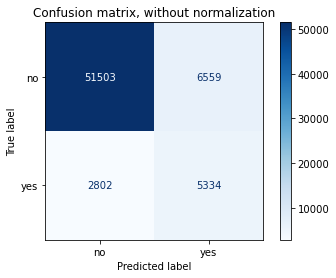

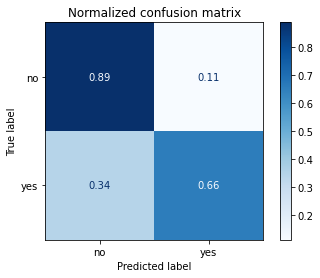

In [361]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(rf, test[features], test['lethal'],
                                 display_labels=['no', 'yes'],
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [362]:
rf.feature_importances_

array([0.00484681, 0.16863358, 0.27523306, 0.13191056, 0.19635273,
       0.12656682, 0.00398136, 0.01912765, 0.0055294 , 0.0043434 ,
       0.00498007, 0.01614381, 0.0072274 , 0.00610067, 0.01328618,
       0.00663356, 0.00910297])

[Text(0, 0, 'sex'),
 Text(1, 0, 'patient_type'),
 Text(2, 0, 'age'),
 Text(3, 0, 'days_to_medical_help'),
 Text(4, 0, 'intubed'),
 Text(5, 0, 'pneumonia'),
 Text(6, 0, 'pregnancy'),
 Text(7, 0, 'diabetes'),
 Text(8, 0, 'copd'),
 Text(9, 0, 'asthma'),
 Text(10, 0, 'inmsupr'),
 Text(11, 0, 'hypertension'),
 Text(12, 0, 'other_disease'),
 Text(13, 0, 'cardiovascular'),
 Text(14, 0, 'obesity'),
 Text(15, 0, 'renal_chronic'),
 Text(16, 0, 'tobacco')]

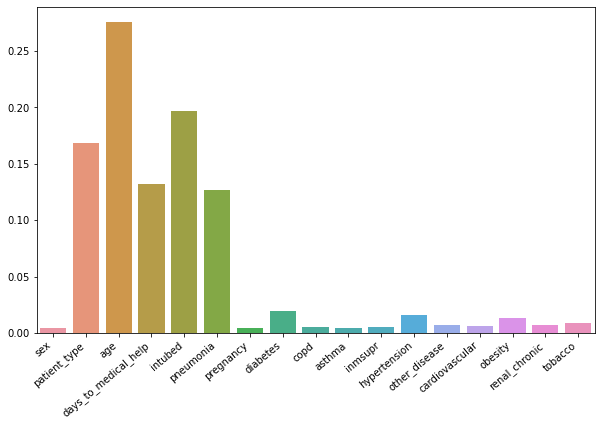

In [366]:
f, ax = plt.subplots(figsize=(10, 6))
sns.barplot(x=train[features].columns, y=rf.feature_importances_)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

In [ ]:
dt = DecisionTreeClassifier(n_estimators=100, min_samples_split=3, max_depth=30).fit(obs, results)

from sklearn import tree
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(dt, 
                   feature_names=train[features].columns.tolist(),
                   class_names=['not lethal', 'lethal'],
                   filled=True)